Папка на GDrive:

https://drive.google.com/drive/folders/1FeUwrVfxp09xAifiMngwtfrRZ8nhtj8T?usp=sharing


In [1]:
from os import listdir

USE_GDRIVE = False


if USE_GDRIVE:
    from google.colab import drive
    drive.mount("/home/GDrive")
    DATA_PATH = f"/home/GDrive/MyDrive/made_2021_fraud_project/data"
else:
    DATA_PATH = "../../data"

GPS_PATH = "../../data/gps_data.csv"
ACCEL_PATH = "../../data/accel_data.csv"

listdir(DATA_PATH)

['drivers_stats.csv',
 'gps_data.csv',
 'unlabeled',
 'good_data',
 'points_stats.csv',
 'all_gps.csv',
 'all_accel.csv',
 'accel_data.csv',
 'drivers_with_gps_and_sl_problems',
 'gps_stats.csv',
 'rides_of_drivers.csv',
 'accel_stats.csv']

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
import folium
from haversine import haversine, Unit
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline

In [3]:
from math import radians, cos, sin, asin, sqrt

def haversine_approx(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    # haversine formula 
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    meters = km * 1000
    return meters

# ЧЛБ - ЕКБ = 193 km
haversine_approx(55.159812, 61.402416, 56.839103, 60.593395)

193261.08011876777

In [4]:
def euclid_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    dist = np.sqrt(dlon**2 + dlat**2)
    return dist

euclid_distance(55.159812, 61.402416, 56.839103, 60.593395)

0.03253311160761813

In [5]:
def describe(df):
    display(pd.concat((df.dtypes, df.describe(datetime_is_numeric=True).T), axis=1))
    display(df.shape)

In [6]:
df_gps = pd.read_csv(GPS_PATH, parse_dates=[0, 3])
describe(df_gps)

,0,count,mean,min,25%,50%,75%,max,std
time,datetime64[ns],5050292,2021-04-06 10:23:00.788006400,2020-10-25 03:59:58,2021-01-16 06:40:41.750000128,2021-04-07 17:01:10.500000,2021-06-22 15:23:15.499999744,2021-08-28 02:47:58,NaN
lat,float64,5.05029e+06,55.743,42.98,55.6674,55.7496,55.8242,82.4343,0.171211
lon,float64,5.05029e+06,37.6021,26.1013,37.5009,37.5848,37.7032,135.46,0.401377
gps_time,datetime64[ns],5050292,2021-04-06 10:22:58.275877632,2020-10-25 03:59:56,2021-01-16 06:40:38.749999872,2021-04-07 17:01:10.500000,2021-06-22 15:23:15.499999744,2021-08-28 02:47:58,NaN
driver_hash,int64,5.05029e+06,3.03558e+17,-9.21858e+18,-4.06958e+18,1.02237e+17,4.79299e+18,9.20647e+18,5.27957e+18
fraud,int64,5.05029e+06,-0.767609,-1,-1,-1,-1,1,0.470076


(5050292, 6)

In [7]:
df_gps["gps_time_diff"] = df_gps["gps_time"].sort_values().diff().dt.total_seconds()
df_gps["gps_time_diff"].fillna(0.0, inplace=True)
df_gps["time_diff"] = df_gps["time"].sort_values().diff().dt.total_seconds()
df_gps["time_diff"].fillna(0.0, inplace=True)
describe(df_gps[["gps_time_diff", "time_diff"]])

,0,count,mean,std,min,25%,50%,75%,max
gps_time_diff,float64,5050292.0,5.251277,480.631651,0.0,1.0,2.0,3.0,458852.0
time_diff,float64,5050292.0,5.251277,473.472848,0.0,1.0,2.0,3.0,432727.0


(5050292, 2)

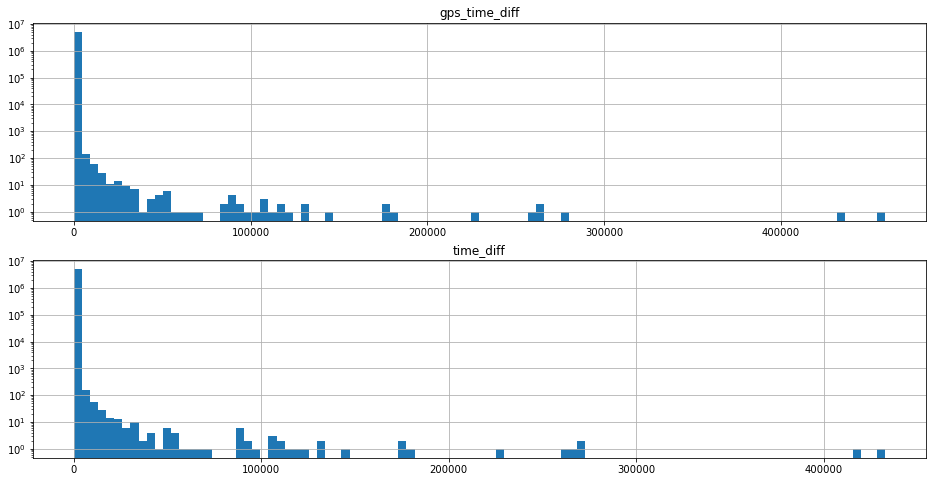

In [8]:
plt.figure(figsize=(16,8))

plt.subplot(211)
df_gps["gps_time_diff"].hist(bins=100)
plt.yscale("log")
plt.title("gps_time_diff")

plt.subplot(212)
df_gps["time_diff"].hist(bins=100)
plt.yscale("log")
plt.title("time_diff")

plt.show()

In [9]:
euclid_v = np.vectorize(euclid_distance)

df_gps["euclid"] = euclid_v(df_gps['lat'], df_gps['lon'], df_gps['lat'].shift(), df_gps['lon'].shift())
df_gps["euclid"].describe()

count    5.050291e+06
mean     6.633749e-06
std      1.726589e-03
min      0.000000e+00
25%      1.745329e-08
50%      1.110035e-06
75%      5.319619e-06
max      1.707277e+00
Name: euclid, dtype: float64

In [10]:
df_gps["euclid"] /= df_gps["euclid"].mean()
df_gps["euclid"].describe()

count    5.050291e+06
mean     1.000000e+00
std      2.602734e+02
min      0.000000e+00
25%      2.630985e-03
50%      1.673315e-01
75%      8.019024e-01
max      2.573624e+05
Name: euclid, dtype: float64

In [11]:
haversine_v = np.vectorize(haversine_approx)

df_gps["distance"] = haversine_v(df_gps['lat'], df_gps['lon'], df_gps['lat'].shift(), df_gps['lon'].shift())
df_gps["distance"].describe()

count    5.050291e+06
mean     2.806352e+01
std      6.080369e+03
min      0.000000e+00
25%      6.217706e-02
50%      5.174056e+00
75%      2.481415e+01
max      6.451089e+06
Name: distance, dtype: float64

In [12]:
df_gps["distance"] = df_gps["distance"].clip(None, 10000)
df_gps["distance"].describe()

count    5.050291e+06
mean     1.962367e+01
std      1.800251e+02
min      0.000000e+00
25%      6.217706e-02
50%      5.174056e+00
75%      2.481415e+01
max      1.000000e+04
Name: distance, dtype: float64

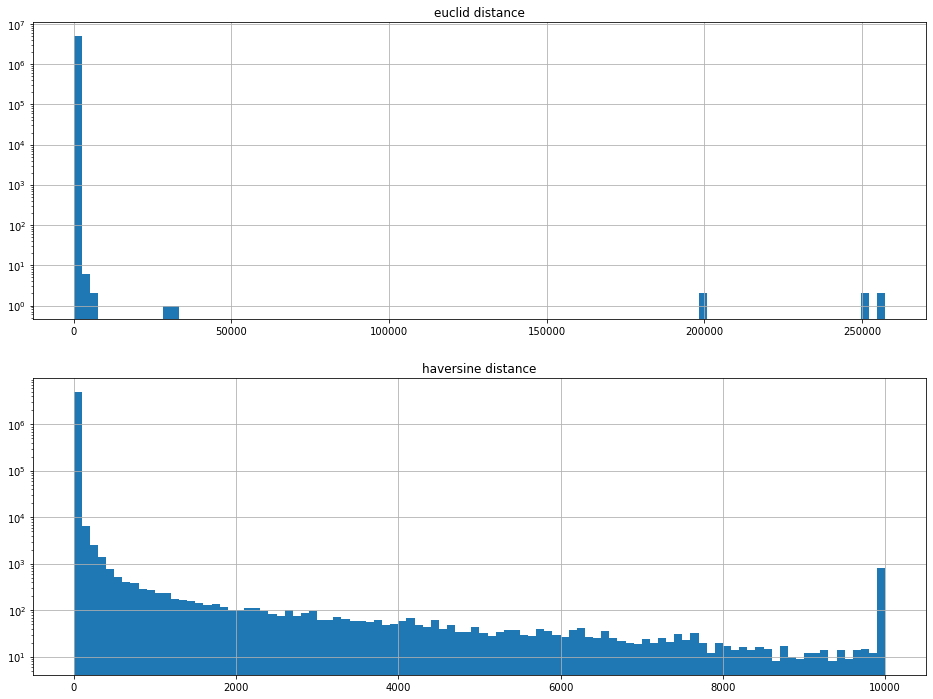

In [13]:
plt.figure(figsize=(16,12))

plt.subplot(211)
df_gps["euclid"].hist(bins=100)
plt.yscale("log")
plt.title("euclid distance")

plt.subplot(212)
df_gps["distance"].hist(bins=100)
plt.yscale("log")
plt.title("haversine distance")

plt.show()

In [14]:
df_gps["gps_chord_speed"] = df_gps["euclid"] / df_gps["gps_time_diff"]
df_gps["gps_chord_speed"] = df_gps["gps_chord_speed"].fillna(0.0).replace(np.inf, 0.0)

df_gps["time_chord_speed"] = df_gps["euclid"] / df_gps["time_diff"]
df_gps["time_chord_speed"] = df_gps["time_chord_speed"].fillna(0.0).replace(np.inf, 0.0)

df_gps["gps_speed"] = df_gps["distance"] / df_gps["gps_time_diff"]
df_gps["gps_speed"] = df_gps["gps_speed"].fillna(0.0).replace(np.inf, 0.0)

df_gps["time_speed"] = df_gps["distance"] / df_gps["time_diff"]
df_gps["time_speed"] = df_gps["time_speed"].fillna(0.0).replace(np.inf, 0.0)

describe(df_gps[["gps_speed", "time_speed", "gps_chord_speed", "time_chord_speed"]])

,0,count,mean,std,min,25%,50%,75%,max
gps_speed,float64,5050292.0,7.815959,74.509422,0.0,0.0,0.935750,10.287300,10000.000000
time_speed,float64,5050292.0,7.711025,73.526568,0.0,0.0,0.863703,10.173558,10000.000000
gps_chord_speed,float64,5050292.0,0.364960,129.116669,0.0,0.0,0.030027,0.331992,251693.125355
time_chord_speed,float64,5050292.0,0.320640,75.178162,0.0,0.0,0.027858,0.328247,128681.193542


(5050292, 4)

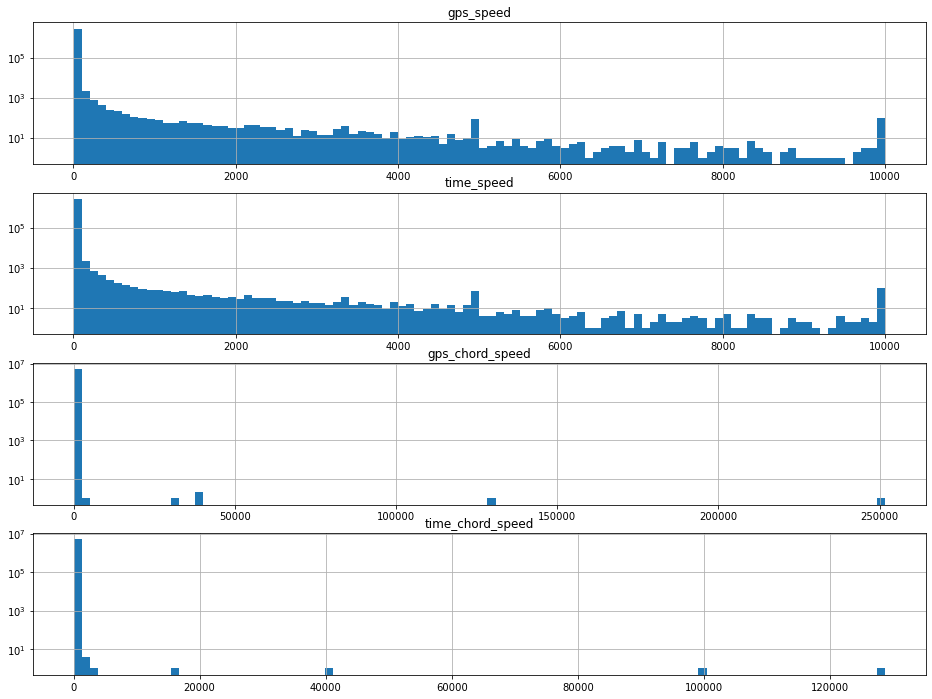

In [15]:
plt.figure(figsize=(16,12))

plt.subplot(411)
df_gps["gps_speed"][df_gps["gps_speed"].round(0) > 0.0].hist(bins=100)
plt.yscale("log")
plt.title("gps_speed")

plt.subplot(412)
df_gps["time_speed"][df_gps["time_speed"].round(0) > 0.0].hist(bins=100)
plt.yscale("log")
plt.title("time_speed")

plt.subplot(413)
df_gps["gps_chord_speed"].hist(bins=100)
plt.yscale("log")
plt.title("gps_chord_speed")

plt.subplot(414)
df_gps["time_chord_speed"].hist(bins=100)
plt.yscale("log")
plt.title("time_chord_speed")

plt.show()

In [16]:
describe(df_gps)

,0,count,mean,min,25%,50%,75%,max,std
time,datetime64[ns],5050292,2021-04-06 10:23:00.788006400,2020-10-25 03:59:58,2021-01-16 06:40:41.750000128,2021-04-07 17:01:10.500000,2021-06-22 15:23:15.499999744,2021-08-28 02:47:58,NaN
lat,float64,5.05029e+06,55.743,42.98,55.6674,55.7496,55.8242,82.4343,0.171211
lon,float64,5.05029e+06,37.6021,26.1013,37.5009,37.5848,37.7032,135.46,0.401377
gps_time,datetime64[ns],5050292,2021-04-06 10:22:58.275877632,2020-10-25 03:59:56,2021-01-16 06:40:38.749999872,2021-04-07 17:01:10.500000,2021-06-22 15:23:15.499999744,2021-08-28 02:47:58,NaN
driver_hash,int64,5.05029e+06,3.03558e+17,-9.21858e+18,-4.06958e+18,1.02237e+17,4.79299e+18,9.20647e+18,5.27957e+18
fraud,int64,5.05029e+06,-0.767609,-1,-1,-1,-1,1,0.470076
gps_time_diff,float64,5.05029e+06,5.25128,0,1,2,3,458852,480.632
time_diff,float64,5.05029e+06,5.25128,0,1,2,3,432727,473.473
euclid,float64,5.05029e+06,1,0,0.00263098,0.167331,0.801902,257362,260.273
distance,float64,5.05029e+06,19.6237,0,0.0621771,5.17406,24.8141,10000,180.025


(5050292, 14)

In [17]:
def map_driver_routs(driver_hash, df=df_gps, min_points=10):
    driver_gps = df_gps[df_gps["driver_hash"] == driver_hash]
    center = (driver_gps["lat"].mean(), driver_gps["lon"].mean())
    m = folium.Map(location=center, zoom_start=10, legend=True)
    
    idx_column = "route_by_gps"
    route_ids = driver_gps[idx_column].unique()
    cmap = list(colors.XKCD_COLORS.values())
    legend = '<span style="color: {col};">by_gps_{txt}_({num})</span>'
    
    for i, idx in enumerate(route_ids):
        route_gps = driver_gps[driver_gps[idx_column] == idx]
        if route_gps.shape[0] < min_points:
            continue
            
        color = cmap[np.random.choice(len(cmap))]
        name = legend.format(txt=idx, col=color, num=route_gps.shape[0])
        fg = folium.FeatureGroup(name).add_to(m)
        folium.PolyLine(route_gps[["lat", "lon"]], color=color, weight=8, opacity=0.8).add_to(fg)
        
    idx_column = "route_by_time"
    route_ids = driver_gps[idx_column].unique()
    cmap = list(colors.XKCD_COLORS.values())
    legend = '<span style="color: {col};">by_time_{txt}_({num})</span>'
    
    for i, idx in enumerate(route_ids):
        route_gps = driver_gps[driver_gps[idx_column] == idx]
        if route_gps.shape[0] < min_points:
            continue
            
        color = cmap[np.random.choice(len(cmap))]
        name = legend.format(txt=idx, col=color, num=route_gps.shape[0])
        fg = folium.FeatureGroup(name).add_to(m)
        folium.PolyLine(route_gps[["lat", "lon"]], color=color, weight=6, opacity=0.8).add_to(fg)

    folium.map.LayerControl('topleft', collapsed= False).add_to(m)
    return m

In [18]:
# [1, 0, -1, None]
FORCE_FRAUD = None

if not FORCE_FRAUD is None:
    cur_driver = np.random.choice(df_gps.loc[df_gps["fraud"] == FORCE_FRAUD, "driver_hash"].unique())
else:
    cur_driver = np.random.choice(df_gps["driver_hash"].unique())

# пример водителя в большим количесвтом сматченных точек
# cur_driver = -6646726793274239750

fraud = df_gps.loc[df_gps["driver_hash"] == cur_driver,"fraud"].values[0]
display(f"Current Driver: {cur_driver} [fraud={fraud}]")

'Current Driver: 5060865697481233184 [fraud=-1]'

In [19]:
df_gps["route_by_gps"] = df_gps["gps_time"].diff().dt.round("120s").cumsum().dt.seconds
num_routes = len(df_gps["route_by_gps"].unique())
display(f"Number of routes by dist: {num_routes}")

df_gps["route_by_time"] = df_gps["time"].diff().dt.round("120s").cumsum().dt.seconds
num_routes = len(df_gps["route_by_time"].unique())
display(f"Number of routes by time: {num_routes}")

map_driver_routs(cur_driver)

'Number of routes by dist: 1439'

'Number of routes by time: 1440'

In [37]:
X = df_gps[[
    'gps_time_diff',
    'time_diff',
    'euclid',
    'distance',
    'gps_chord_speed',
    'time_chord_speed',
    'gps_speed',
    'time_speed'
]].copy().replace(np.nan, 0.0)

describe(X)

pca = PCA(n_components=2)
df_gps.loc[:,["pca_x","pca_y"]] = pca.fit_transform(X)

,0,count,mean,std,min,25%,50%,75%,max
gps_time_diff,float64,5050292.0,5.251277,480.631651,0.0,1.000000,2.000000,3.000000,458852.000000
time_diff,float64,5050292.0,5.251277,473.472848,0.0,1.000000,2.000000,3.000000,432727.000000
euclid,float64,5050292.0,1.000000,260.273406,0.0,0.002631,0.167331,0.801902,257362.387083
distance,float64,5050292.0,19.623665,180.025051,0.0,0.062177,5.174033,24.814145,10000.000000
gps_chord_speed,float64,5050292.0,0.364960,129.116669,0.0,0.000000,0.030027,0.331992,251693.125355
time_chord_speed,float64,5050292.0,0.320640,75.178162,0.0,0.000000,0.027858,0.328247,128681.193542
gps_speed,float64,5050292.0,7.815959,74.509422,0.0,0.000000,0.935750,10.287300,10000.000000
time_speed,float64,5050292.0,7.711025,73.526568,0.0,0.000000,0.863703,10.173558,10000.000000


(5050292, 8)

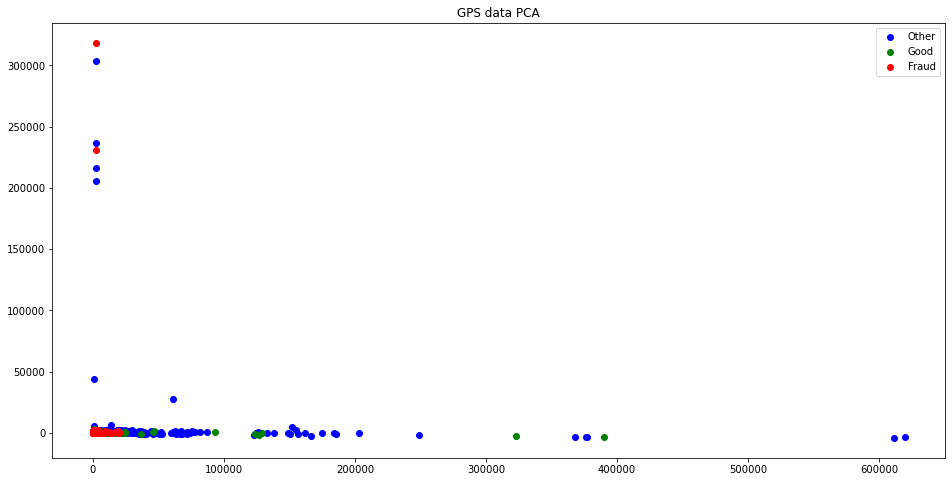

In [38]:
plt.figure(figsize=(16,8))

df_other = df_gps[df_gps["fraud"] == -1]
plt.scatter(df_other["pca_x"], df_other["pca_y"], color="blue", label="Other")

df_proper = df_gps[df_gps["fraud"] == 0]
plt.scatter(df_proper["pca_x"], df_proper["pca_y"], color="green", label="Good")

df_fraud = df_gps[df_gps["fraud"] == 1]
plt.scatter(df_fraud["pca_x"], df_fraud["pca_y"], color="red", label="Fraud")

plt.legend()
plt.title("GPS data PCA")
plt.show()

In [39]:
X = df_gps[[
    'gps_time_diff',
    'time_diff',
    'euclid',
    'distance',
    'gps_chord_speed',
    'time_chord_speed',
    'gps_speed',
    'time_speed',
    'route_by_gps'
]].copy().replace(np.nan, 0.0)

describe(X)

pca = PCA(n_components=2)
df_gps.loc[:,["pca_x","pca_y"]] = pca.fit_transform(X)

,0,count,mean,std,min,25%,50%,75%,max
gps_time_diff,float64,5050292.0,5.251277,480.631651,0.0,1.000000,2.000000,3.000000,458852.000000
time_diff,float64,5050292.0,5.251277,473.472848,0.0,1.000000,2.000000,3.000000,432727.000000
euclid,float64,5050292.0,1.000000,260.273406,0.0,0.002631,0.167331,0.801902,257362.387083
distance,float64,5050292.0,19.623665,180.025051,0.0,0.062177,5.174033,24.814145,10000.000000
gps_chord_speed,float64,5050292.0,0.364960,129.116669,0.0,0.000000,0.030027,0.331992,251693.125355
time_chord_speed,float64,5050292.0,0.320640,75.178162,0.0,0.000000,0.027858,0.328247,128681.193542
gps_speed,float64,5050292.0,7.815959,74.509422,0.0,0.000000,0.935750,10.287300,10000.000000
time_speed,float64,5050292.0,7.711025,73.526568,0.0,0.000000,0.863703,10.173558,10000.000000
route_by_gps,float64,5050292.0,43514.142869,24918.530117,0.0,22396.000000,42796.000000,65596.000000,86356.000000


(5050292, 9)

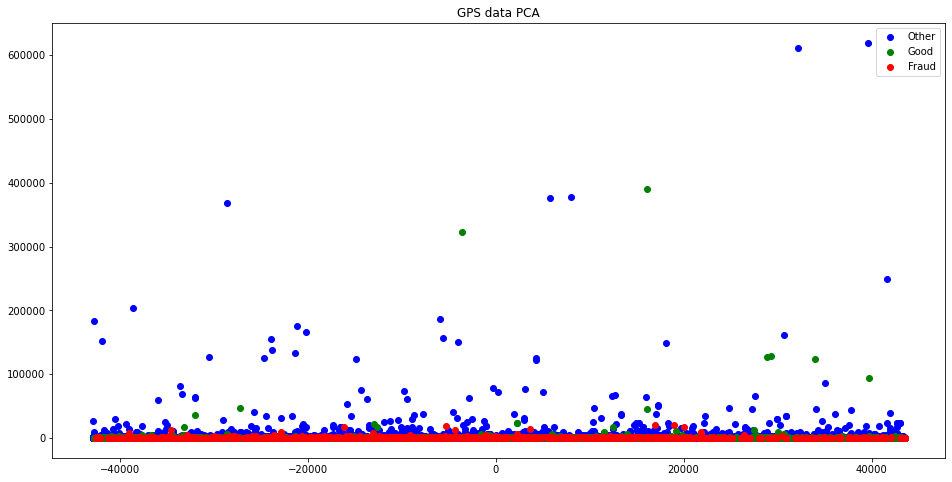

In [41]:
plt.figure(figsize=(16,8))

df_other = df_gps[df_gps["fraud"] == -1]
plt.scatter(df_other["pca_x"], df_other["pca_y"], color="blue", label="Other")

df_proper = df_gps[df_gps["fraud"] == 0]
plt.scatter(df_proper["pca_x"], df_proper["pca_y"], color="green", label="Good")

df_fraud = df_gps[df_gps["fraud"] == 1]
plt.scatter(df_fraud["pca_x"], df_fraud["pca_y"], color="red", label="Fraud")

plt.legend()
plt.title("GPS data PCA")
plt.show()

In [42]:
X = df_gps[[
    'gps_time_diff',
    'time_diff',
    'euclid',
    'distance',
    'gps_chord_speed',
    'time_chord_speed',
    'gps_speed',
    'time_speed',
    'route_by_gps',
    'route_by_time'
]].copy().replace(np.nan, 0.0)

describe(X)

pca = PCA(n_components=2)
df_gps.loc[:,["pca_x","pca_y"]] = pca.fit_transform(X)

,0,count,mean,std,min,25%,50%,75%,max
gps_time_diff,float64,5050292.0,5.251277,480.631651,0.0,1.000000,2.000000,3.000000,458852.000000
time_diff,float64,5050292.0,5.251277,473.472848,0.0,1.000000,2.000000,3.000000,432727.000000
euclid,float64,5050292.0,1.000000,260.273406,0.0,0.002631,0.167331,0.801902,257362.387083
distance,float64,5050292.0,19.623665,180.025051,0.0,0.062177,5.174033,24.814145,10000.000000
gps_chord_speed,float64,5050292.0,0.364960,129.116669,0.0,0.000000,0.030027,0.331992,251693.125355
time_chord_speed,float64,5050292.0,0.320640,75.178162,0.0,0.000000,0.027858,0.328247,128681.193542
gps_speed,float64,5050292.0,7.815959,74.509422,0.0,0.000000,0.935750,10.287300,10000.000000
time_speed,float64,5050292.0,7.711025,73.526568,0.0,0.000000,0.863703,10.173558,10000.000000
route_by_gps,float64,5050292.0,43514.142869,24918.530117,0.0,22396.000000,42796.000000,65596.000000,86356.000000
route_by_time,float64,5050292.0,42610.682436,25732.953453,0.0,19723.000000,42076.000000,65443.000000,86356.000000


(5050292, 10)

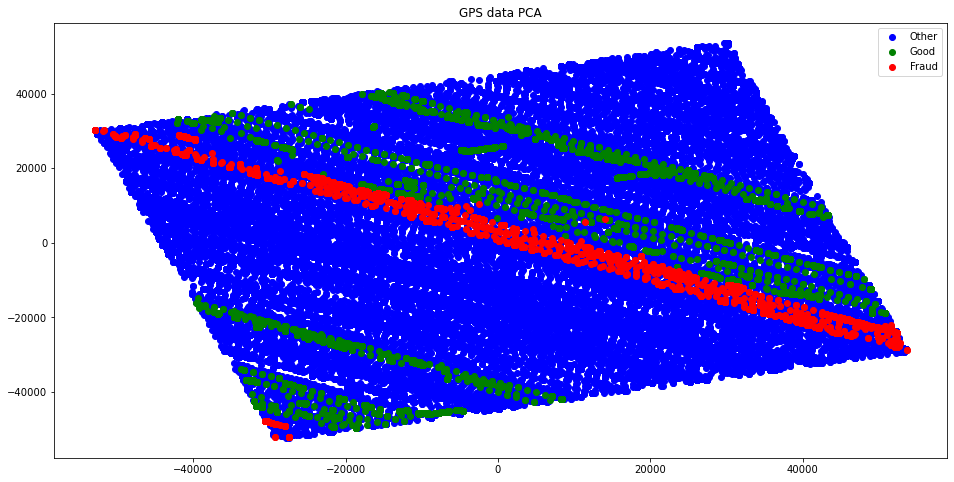

In [43]:
plt.figure(figsize=(16,8))

df_other = df_gps[df_gps["fraud"] == -1]
plt.scatter(df_other["pca_x"], df_other["pca_y"], color="blue", label="Other")

df_proper = df_gps[df_gps["fraud"] == 0]
plt.scatter(df_proper["pca_x"], df_proper["pca_y"], color="green", label="Good")

df_fraud = df_gps[df_gps["fraud"] == 1]
plt.scatter(df_fraud["pca_x"], df_fraud["pca_y"], color="red", label="Fraud")

plt.legend()
plt.title("GPS data PCA")
plt.show()

In [44]:
X = df_gps[[
    'gps_time_diff',
    'time_diff',
    'euclid',
    'distance',
    'gps_chord_speed',
    'time_chord_speed',
    'gps_speed',
    'time_speed'
]].copy().replace(np.nan, 0.0)

describe(X)

,0,count,mean,std,min,25%,50%,75%,max
gps_time_diff,float64,5050292.0,5.251277,480.631651,0.0,1.000000,2.000000,3.000000,458852.000000
time_diff,float64,5050292.0,5.251277,473.472848,0.0,1.000000,2.000000,3.000000,432727.000000
euclid,float64,5050292.0,1.000000,260.273406,0.0,0.002631,0.167331,0.801902,257362.387083
distance,float64,5050292.0,19.623665,180.025051,0.0,0.062177,5.174033,24.814145,10000.000000
gps_chord_speed,float64,5050292.0,0.364960,129.116669,0.0,0.000000,0.030027,0.331992,251693.125355
time_chord_speed,float64,5050292.0,0.320640,75.178162,0.0,0.000000,0.027858,0.328247,128681.193542
gps_speed,float64,5050292.0,7.815959,74.509422,0.0,0.000000,0.935750,10.287300,10000.000000
time_speed,float64,5050292.0,7.711025,73.526568,0.0,0.000000,0.863703,10.173558,10000.000000


(5050292, 8)

In [ ]:
tsne = TSNE(n_components=2, n_jobs=-1)
df_gps.loc[:,["tsne_x","tsne_y"]] = tsne.fit_transform(X)

In [ ]:
plt.figure(figsize=(16,8))

df_other = df_gps[df_gps["fraud"] == -1]
plt.scatter(df_other["tsne_x"], df_other["tsne_y"], color="blue", label="Other")

df_fraud = df_gps[df_gps["fraud"] == 1]
plt.scatter(df_fraud["tsne_x"], df_fraud["tsne_y"], color="red", label="Fraud")

df_proper = df_gps[df_gps["fraud"] == 0]
plt.scatter(df_proper["tsne_x"], df_proper["tsne_y"], color="green", label="Good")


plt.legend()
plt.title("GPS data TSNE")
plt.show()